# Using OCR Bounding Boxes and Images to evaluate text confidence

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Corrupt JPEG data: bad Huffman code
/var/folders/pz/bsrlw1051zq7wv21r5cq1y280000gn/T/ipykernel_5637/583419840.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


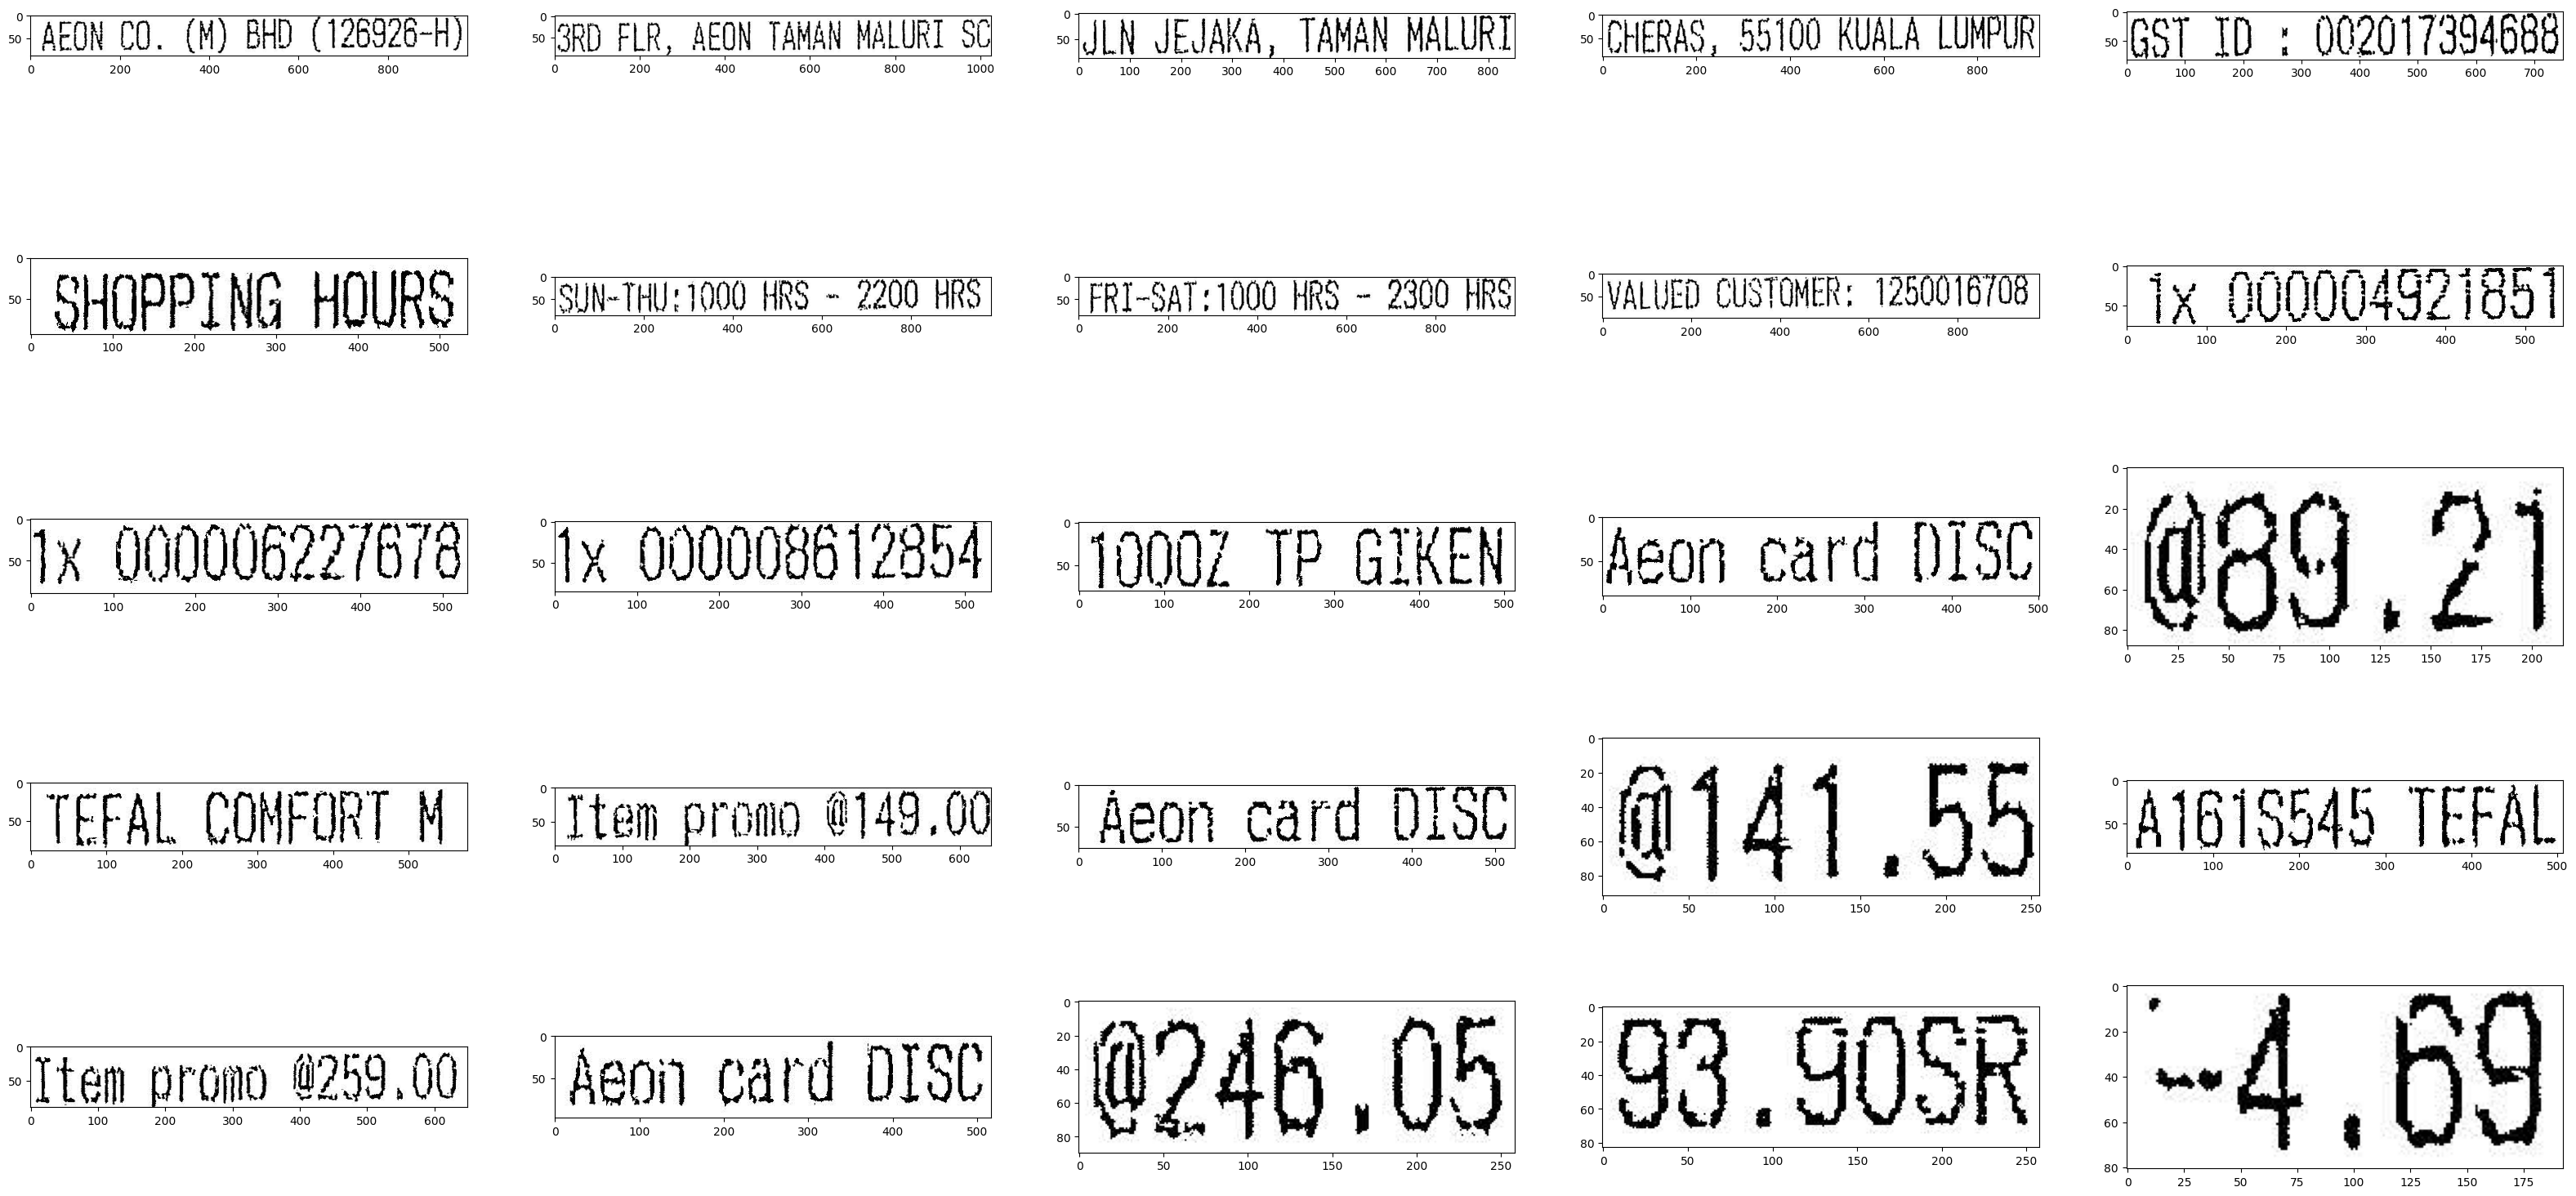

In [50]:
testfile = '00d0100894168'
img = cv2.imread(f'data/original/img/{testfile}.jpg')
imgdata = pd.read_csv(f"data/interim/ocr/{testfile}.csv")

fig, ax = plt.subplots(5,5,figsize=(40,20))
ctr = 0
for row in imgdata.iterrows():
    if int(row[1]['BB1']) < int(row[1]['BB3']) and int(row[1]['BB2']) < int(row[1]['BB6']):
        slc = img[int(row[1]['BB2']):int(row[1]['BB6'])+1, int(row[1]['BB1']):int(row[1]['BB3'])+1]
        if ctr < 25:
            ax[ctr//5][ctr%5].imshow(slc)
            ctr += 1
fig.show()
